In [86]:
from __future__ import division
import os
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy as scp
import pylab as pyl

import warnings
warnings.filterwarnings('ignore')
np.random.seed(1234)

%matplotlib inline
%load_ext autoreload
%autoreload 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
if not os.path.isdir('DampedNewtonPreconditioningAllversions_images'):
    os.makedirs('DampedNewtonPreconditioningAllversions_images')

In [89]:
"""To compute distance matrix"""
def distmat(x,y):
    return np.sum( x**2,0 )[:,None] + np.sum( y**2,0 )[None,:] - 2*x.transpose().dot(y)

"""To Normalise a vector"""
normalize = lambda a: a/np.sum( a )

"""To Compute P"""
def GetP(f,K,g):
    u = np.exp(f).reshape(f.shape[0],)
    v = np.exp(g).reshape(g.shape[0],)
    return u[:,None]*K*v[None,:]

def plotp(x, col,plt, scale=200, edgecolors="k"):
  return plt.scatter( x[0,:], x[1,:], s=scale, edgecolors=edgecolors,  c=col, cmap='plasma', linewidths=2 )

In [90]:
N = [ 400,500 ]

In [91]:
x = np.random.rand( 2,N[0] )-0.5
theta = 2*np.pi*np.random.rand( 1,N[1] )
r = 0.8+.2*np.random.rand( 1,N[1] )
y = np.vstack( ( r*np.cos( theta ),r*np.sin( theta ) ) )

In [92]:
import computational_OT

# 0. Sinkhorn vs damped Newton

## 0.1. Sinkhorn

In [96]:
# Sinkhorn
print("Sinkhorn.... ")
SinkhornP=[]
results_Sinkhorn=[]
times_Sinkhorn=[]
epsilons=[ 1.0, 0.75, 0.5, 0.4, 0.3, 0.1, 0.05,0.03]
Pmatrix_dist_linVSsinkhorn=[]
for eps in epsilons:

  
  #Cost matrix
  C = distmat(x,y)
  
  # a and b
  a = normalize(np.ones(N[0]))
  a=a.reshape(a.shape[0],-1)
  b = normalize(np.ones(N[1]))
  b=b.reshape(b.shape[0],-1)



  #Kernel
  K=np.exp(-C/eps)


  print("Doing for (",N[0],N[1],").")
  print( " |- Iterating")

  #Inflating
  u=a
  v=b

  start=time.time()
  Optimizer=computational_OT.Sinkhorn(K,a,b,u,v,eps)
  out=Optimizer._update()
  results_Sinkhorn.append(out)
  end=time.time()
  times_Sinkhorn.append(end-start)
  print( " |- Computing P")
  print( "" )
  SinkhornP.append(GetP(out['potential_f']/eps,K,out['potential_g']/eps))
  

Sinkhorn.... 
Doing for ( 400 500 ).
 |- Iterating
Terminating after iteration:  11
 |- Computing P

Doing for ( 400 500 ).
 |- Iterating
Terminating after iteration:  14
 |- Computing P

Doing for ( 400 500 ).
 |- Iterating
Terminating after iteration:  21
 |- Computing P

Doing for ( 400 500 ).
 |- Iterating
Terminating after iteration:  26
 |- Computing P

Doing for ( 400 500 ).
 |- Iterating
Terminating after iteration:  36
 |- Computing P

Doing for ( 400 500 ).
 |- Iterating
Terminating after iteration:  116
 |- Computing P

Doing for ( 400 500 ).
 |- Iterating
Terminating after iteration:  243
 |- Computing P

Doing for ( 400 500 ).
 |- Iterating
Terminating after iteration:  414
 |- Computing P



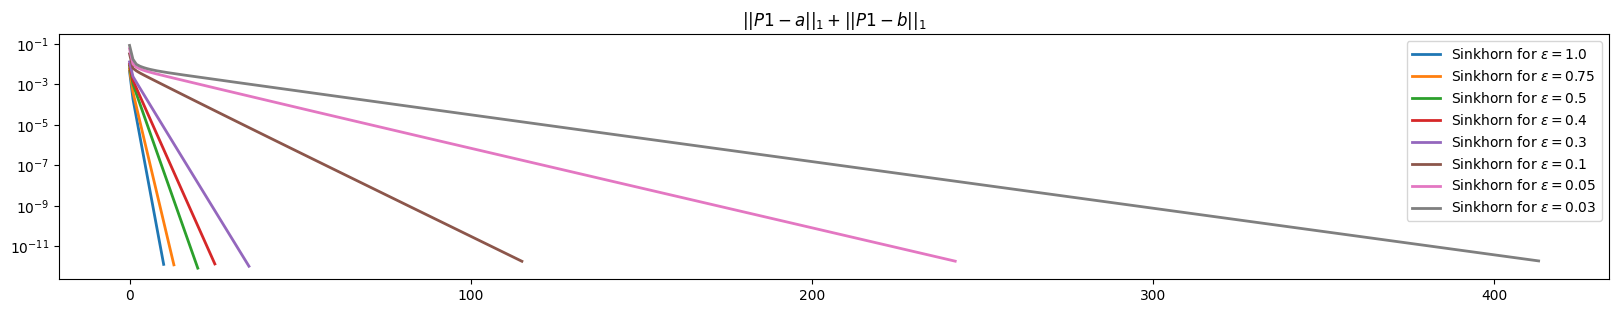

In [97]:
plt.figure( figsize = (20,7) )

plt.subplot(2,1,1),
plt.title( "$||P1 -a||_1+||P1 -b||_1$" )
for i in range( len(results_Sinkhorn) ):
  error=np.asarray( results_Sinkhorn[i]['error_a'] )+np.asarray( results_Sinkhorn[i]['error_b'] )
  plt.plot( error,label='Sinkhorn for $\epsilon=$'+ str(epsilons[i]), linewidth = 2 )
plt.yscale( 'log' )
plt.legend()

plt.savefig("DampedNewtonPreconditioningAllversions_images/ConvergenceSinkhornvaryingepsilon.png")
plt.show()

## 0.2. Damped Newton-Raphson

In [ ]:
rho = 0.95
c = 0.05
DampedNewtonP = []
results_DampedNewton  = []
times_DampedNewton    = []
Hessians_DampedNewton = []

#epsilons=[0.05,0.08,0.1]
# epsilons=[0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1.0 ]
epsilons = [ 1.0, 0.75, 0.5, 0.4, 0.3, 0.1, 0.05,0.03 ]
#epsilons=[0.3]
for eps in epsilons:
    # Line Search
    print( "Damped Newton for epsilon="+str(eps)+":" )    
    #Cost matrix
    C = distmat(x,y)

    # a and b
    a = normalize( np.ones( N[0] ) )
    a = a.reshape( a.shape[0],-1 )
    b = normalize( np.ones( N[1] ) )
    b = b.reshape( b.shape[0],-1 )

    #Kernel
    K = np.exp(-C/eps)
    f,g = a,b

    print( "Doing for (",N[0],N[1],")." )
    print( " |- Iterating" )  
    start = time.time()
    Optimizer = computational_OT.DampedNewton( K,a,b,f,g,eps,rho,c )
    out = Optimizer._update( maxiter=50 )
    results_DampedNewton.append( out )
    end = time.time()
    times_DampedNewton.append( end-start )
    print( " |- Computing P" )
    DampedNewtonP.append( GetP(np.exp(out['potential_f']/eps),K,np.exp(out['potential_g']/eps)) )
    print( " |- Recording (unstabilized) Hessian \n" )

    mat  = -eps*Optimizer.Hessian
    diag = 1/np.sqrt( np.vstack( (a,b) ) ).flatten()
    mat = diag[:,None]*mat*diag[None,:]
    Hessians_DampedNewton.append( mat )


In [ ]:
plt.figure( figsize = (20,7) )
plt.title( "$$" )
plt.title( "$||P1 -a||_1+||P^T 1 -b||_1$" )

for i in range(len(results_DampedNewton)):
  error = np.asarray( results_DampedNewton[i]['error_a'] )+np.asarray( results_DampedNewton[i]['error_b'] )
  plt.plot( error,label='Damped Newton for $\epsilon=$'+ str(epsilons[i]), linewidth = 2 )

plt.xlabel( "Number of iterations" )
plt.ylabel( "Error in log-scale" )
plt.legend()
plt.yscale( 'log' )
plt.savefig( "DampedNewtonPreconditioningAllversions_images/ErrorDampedNewtonwithoutPrecond.png" )
plt.show()

print( "\n Error plots can increase! The error is not the objective function!" )

In [ ]:
plt.figure( figsize = (20,7) )
plt.title( "$$" )

plt.title( "Objective Function" )
for i in range(len(results_DampedNewton)):
  plt.plot( np.asarray( results_DampedNewton[i]["objectives"] ),label='Damped Newton for $\epsilon=$'+ str(epsilons[i]), linewidth = 2 )

plt.xlabel( "Number of iterations" )
plt.ylabel( "Objective value" )
plt.legend()
plt.savefig("DampedNewtonPreconditioningAllversions_images/ObjectiveDampedNewtonwithoutPrecond.png")
plt.show()


In [ ]:
plt.figure( figsize = (20,7) )
plt.subplot(2,1,1),
plt.title( "Alpha" )

for i in range(len(results_DampedNewton)):
  plt.plot( np.asarray( results_DampedNewton[i]['linesearch_steps'] ),label='Damped Newton for $\epsilon=$'+ str(epsilons[i]), linewidth = 2 )

plt.xlabel( "Number of iterations" )
plt.ylabel( "Alpha in log-scale" )
plt.legend()
# plt.yscale( 'log')
plt.savefig("DampedNewtonPreconditioningAllversions_images/AlphaDampedNewtonwithoutPrecond.png")
plt.show()



# I. Plotting spectrum as a function of $\varepsilon$

In [ ]:
def spectral_decomposition(mat):
    eig, v = np.linalg.eigh( mat )
    sorting_indices = np.argsort(eig)
    eig = eig[sorting_indices]
    v   = v[:, sorting_indices]
    
    print( "List of smallest eigenvalues: ", eig[:10])
    print( "List of largest  eigenvalues: ", eig[-10:])

    return eig,v

In [ ]:
eigs = []
eigvecs = []
for i in range( len(epsilons) ) :
    eps = epsilons[i]
    print( "Spectral statistics of Hessian for epsilon="+str(eps) )
    ev = spectral_decomposition( Hessians_DampedNewton[i] )
    eigs.append( ev[0] )
    eigvecs.append( ev[1] )
    print("")


In [ ]:
fig,ax = plt.subplots( figsize=(24,3),nrows=1, ncols=len(epsilons), sharey=True )
plt.title( "Histogram of eigenvalues." )
for i in range( len(epsilons) ):
    ax[i].hist( eigs[i], 50 )
    ax[i].set_title( " $\epsilon$: "+str(epsilons[i]) )
    ax[i].set_xlabel( "Eigenvalues" )
    ax[i].set_yscale( "log" )
plt.subplots_adjust( wspace=0,hspace=0 )
plt.savefig("DampedNewtonPreconditioningAllversions_images/eigenhistunstabilizedDampedNewtonwithoutPrecond.png")
plt.show()

# II. Actual preconditioning

In [ ]:
def build_preconditioners( num_eigs,modified_Hessian, ansatz=True ):
    # Diagonalize
    eigenvalues, eigenvectors = np.linalg.eigh( modified_Hessian )
    sorting_indices = np.argsort( eigenvalues )
    eigenvalues  = eigenvalues[sorting_indices]
    eigenvectors = eigenvectors[:, sorting_indices]
    # Form null vector
    if not ansatz:
        null_vector = eigenvectors[:, 0]
    else:
        null_vector = np.hstack( (np.ones(N[0]), -np.ones(N[1])) )
        norm = np.sqrt( N[0] + N[1] )
        null_vector = null_vector/norm
    # Form other vectors (only 13)
    n,m = eigenvectors.shape
    indices=[]
    for i in range(num_eigs//2):
        indices.append(m-i-1)
        indices.append(i+1)
    if num_eigs//2!=0:
        indices.append(m-1-num_eigs//2)
   
    precond_vectors = eigenvectors[:, indices ]
    precond_vectors = []
    for index in indices:
        precond_vectors.append( eigenvectors[:,index] )
    #
    return null_vector, precond_vectors

In [ ]:
num_eigs = 13
null_vector, precond_vectors = build_preconditioners( num_eigs, Hessians_DampedNewton[-1], ansatz=False )

## Version 1

In [ ]:
rho = 0.95
c = 0.05
reset_starting_point = True
final_modified_Hessians = []
DampedNewtonP = []
results_DampedNewton  = []
times_DampedNewton    = []

#epsilons=[ 0.05,0.08,0.1 ]
#precond_epsilons=[ 0.2, 0.3, 0.4, 0.5, 0.75, 1.0 ]
precond_epsilons = [ 1.0, 0.75, 0.5, 0.4, 0.3, 0.1, 0.05]
#epsilons=[ 0.3 ]
f, g = None, None
for eps in precond_epsilons:
    # Line Search
    print( "Damped Newton for epsilon="+str(eps)+":" )    
    # Cost matrix
    C = distmat(x,y)

    # a and b
    a = normalize( np.ones(N[0]) )
    a = a.reshape( a.shape[0],-1 )
    b = normalize( np.ones(N[1]) )
    b = b.reshape( b.shape[0],-1 )

    #Kernel
    K = np.exp(-C/eps)

    if (f is None) or (g is None): 
        f,g=a,b

    print( "Doing for (",N[0],N[1],")." )
    print( " |- Iterating" )   
    start = time.time()
    Optimizer = computational_OT.DampedNewton_With_Preconditioner( K,a,b,f,g,eps,rho,c,null_vector,precond_vectors[:] )
    out = Optimizer._update( maxiter=50, iterative_inversion=30, version=1,debug=False )
    results_DampedNewton.append( out )
    end=time.time()
    times_DampedNewton.append( end-start )
    print( " |- Computing P")

    if not reset_starting_point:
        f = Optimizer.x[:a.shape[0]]
        g = Optimizer.x[a.shape[0]:]
        # f = f.reshape( f.shape[0], -1)
        # g = g.reshape( g.shape[0], -1)
    
    DampedNewtonP.append( GetP( np.exp(out['potential_f']/eps),K,np.exp(out['potential_g']/eps) ) )
    final_modified_Hessians.append( Optimizer.modified_Hessian )


#### Averaged Time plot

In [ ]:
text = [ "Initial preconditioning",
        "Preconditioning matrix formation",
        "Debug Step",
        "Invert the linear system for p_k",
        "Unwinding",
        " Complete code block" 
       ]

plt.figure( figsize = (20,10) )  
for j in range( len(results_DampedNewton[0]['timings'][0]) ):
  values = []
  for i in range( len(results_DampedNewton) ):
    mean = 0
    for k in range( len(results_DampedNewton[i]['timings']) ):
      mean += results_DampedNewton[i]['timings'][k][j]
    mean = mean/len(results_DampedNewton[i]['timings']) 
    values.append( mean )
  if len(precond_epsilons) == len(values):
    plt.plot( precond_epsilons, np.asarray(values), label=text[j],linewidth = 2 )
    plt.legend( loc='upper left' )
plt.xlabel( "Epsilons" )
plt.ylabel( "Time in ms" )
plt.show()

#### Time plot

In [ ]:
text = [ "Initial preconditioning",
       "Preconditioning matrix formation",
       "Debug Step",
        "Invert the linear system for p_k",
        "Unwinding",
        "Complete code block" 
       ]

for i in range( len(results_DampedNewton) ):

  plt.figure( figsize = (20,10) ) 
  plt.title( "Epsilon: "+str(epsilons[i]) ) 
  for j in range( len(results_DampedNewton[0]['timings'][0]) ):
    values = []
    for k in range( len(results_DampedNewton[i]['timings']) ):
      values.append(results_DampedNewton[i]['timings'][k][j])
    plt.plot( np.asarray(values),label = text[j],linewidth = 2 )
  plt.legend( loc='upper right' )
  plt.xlabel( "Iterations" )
  plt.ylabel( "Time in ms" )
  plt.show()

#### Error plot

In [ ]:
plt.figure( figsize = (20,7) )
plt.title( "$$" )
plt.title( "$||P1 -a||_1+||P^T 1 -b||_1$" ) 

for i in range( len(results_DampedNewton) ):
  error = np.asarray( results_DampedNewton[i]['error_a'] )+np.asarray( results_DampedNewton[i]['error_b'] )
  plt.plot( error,label='Damped Newton for $\epsilon=$'+ str(precond_epsilons[i]), linewidth = 2 )

plt.xlabel( "Number of iterations" )
plt.ylabel( "Error in log-scale" )
plt.legend()
plt.yscale( 'log' )
plt.savefig( "DampedNewtonPreconditioningAllversions_images/ErrorDampedNewtonwithoutPrecondV1.png" )
plt.show()

print( "\n Error plots can increase! The error is not the objective function!" )

#### Objective function plot

In [ ]:
plt.figure( figsize = (20,7) )
plt.title( "$$" )

plt.title( "Minus the Objective Function" )

for i in range( len(results_DampedNewton) ):
  plt.plot( -np.asarray(results_DampedNewton[i]['objectives']),label='Damped Newton for $\epsilon=$'+ str(precond_epsilons[i]), linewidth = 2 )

plt.xlabel( "Number of iterations" )
plt.ylabel( "Objective value" )
plt.yscale( 'log' )
plt.legend()
plt.savefig( "DampedNewtonPreconditioningAllversions_images/ObjectiveDampedNewtonwithPrecondV1.png" )
plt.show()

#### Alpha plot

In [ ]:
plt.figure( figsize = (20,7) )
plt.subplot(2,1,1),
plt.title( "Alpha" )
for i in range( len(results_DampedNewton) ):
  plt.plot( np.asarray(results_DampedNewton[i]['linesearch_steps']),label='Damped Newton for $\epsilon=$'+ str(precond_epsilons[i]), linewidth = 2 )

plt.xlabel( "Number of iterations" )
plt.ylabel( "Alpha in log-scale" )
plt.legend()
# plt.yscale( 'log')
plt.savefig( "DampedNewtonPreconditioningAllversions_images/AlphaDampedNewtonwithPrecondv1.png" )
plt.show()


##  Version 2

In [ ]:
rho = 0.95
c = 0.05
reset_starting_point = True
final_modified_Hessians = []
DampedNewtonP = []
results_DampedNewton  = []
times_DampedNewton    = []

#epsilons = [ 0.05,0.08,0.1 ]
#precond_epsilons = [ 0.2, 0.3, 0.4, 0.5, 0.75, 1.0 ]
precond_epsilons = [ 1.0, 0.75, 0.5, 0.4, 0.3, 0.1, 0.05 ]
#epsilons=[ 0.3 ]
f, g = None, None
for eps in precond_epsilons:
    # Line Search
    print( "Damped Newton for epsilon="+str(eps)+":" )    
    # Cost matrix
    C = distmat(x,y)

    # a and b
    a = normalize( np.ones(N[0]) )
    a = a.reshape( a.shape[0],-1 )
    b = normalize( np.ones(N[1]) )
    b = b.reshape( b.shape[0],-1 )

    #Kernel
    K = np.exp(-C/eps)

    if (f is None) or (g is None): 
        f,g=a,b

    print( "Doing for (",N[0],N[1],")." )
    print( " |- Iterating" )  
    start = time.time()
    Optimizer = computational_OT.DampedNewton_With_Preconditioner( K,a,b,f,g,eps,rho,c,null_vector,precond_vectors[:] )
    out = Optimizer._update( maxiter=50, iterative_inversion=30, version=2,debug=False )
    results_DampedNewton.append( out )
    end = time.time()
    times_DampedNewton.append(end-start)
    print( " |- Computing P" )

    if not reset_starting_point:
        f = Optimizer.x[:a.shape[0]]
        g = Optimizer.x[a.shape[0]:]
        # f = f.reshape( f.shape[0], -1)
        # g = g.reshape( g.shape[0], -1)
    
    DampedNewtonP.append( GetP(np.exp(out['potential_f']/eps),K,np.exp(out['potential_g']/eps)) )
    final_modified_Hessians.append( Optimizer.modified_Hessian )


#### Averaged Time plot

In [ ]:
text = [
        "Initial preconditioning",
        "Preconditioning matrix formation",
        "Changing A to PAP",
        "Debug step",
        "Invert the linear system for p_k",
        "Unwinding",
        " Complete code block"
        ]

plt.figure( figsize = (20,10) )  
for j in range( len(results_DampedNewton[0]['timings'][0]) ):
  values = []
  for i in range( len(results_DampedNewton) ):
    mean = 0
    for k in range( len(results_DampedNewton[i]['timings']) ):
      mean += results_DampedNewton[i]['timings'][k][j]
    mean = mean/len(results_DampedNewton[i]['timings']) 
    values.append( mean )
  if len(precond_epsilons) == len(values):
    plt.plot( precond_epsilons, np.asarray(values), label=text[j],linewidth = 2 )
    plt.legend( loc='upper left' )
plt.xlabel( "Epsilons" )
plt.ylabel( "Time in ms" )
plt.show()

#### Time plot

In [ ]:
text = [
        "Initial preconditioning",
        "Preconditioning matrix formation",
        "Changing A to PAP",
        "Debug step",
        "Invert the linear system for p_k",
        "Unwinding",
        " Complete code block"
        ]

for i in range(len(results_DampedNewton)):

  plt.figure( figsize = (20,10) ) 
  plt.title( "Epsilon: "+str(epsilons[i]) ) 
  for j in range( len(results_DampedNewton[0]['timings'][0]) ):
    values = []
    for k in range( len(results_DampedNewton[i]['timings']) ):
      values.append( results_DampedNewton[i]['timings'][k][j] )
    plt.plot( np.asarray(values),label = text[j],linewidth = 2 )
  plt.legend( loc='upper right' )
  plt.xlabel( "Iterations" )
  plt.ylabel( "Time in ms" )
  plt.show()

#### Error plot

In [ ]:
plt.figure( figsize = (20,7) )
plt.title( "$$" )
plt.title( "$||P1 -a||_1+||P^T 1 -b||_1$" )

for i in range( len(results_DampedNewton) ):
  error = np.asarray( results_DampedNewton[i]['error_a'] )+np.asarray( results_DampedNewton[i]['error_b'] )
  plt.plot( error,label='Damped Newton for $\epsilon=$'+ str(precond_epsilons[i]), linewidth = 2 )

plt.xlabel( "Number of iterations" )
plt.ylabel( "Error in log-scale" )
plt.legend()
plt.yscale( 'log' )
plt.savefig( "DampedNewtonPreconditioningAllversions_images/ErrorDampedNewtonwithPrecondV2.png" )
plt.show()

print( "\n Error plots can increase! The error is not the objective function!" )

#### Objective function plot

In [ ]:
plt.figure( figsize = (20,7) )
plt.title( "$$" )

plt.title( "Minus the Objective Function" )

for i in range( len(results_DampedNewton) ):
  plt.plot( -np.asarray( results_DampedNewton[i]['objectives'] ),label='Damped Newton for $\epsilon=$'+ str(precond_epsilons[i]), linewidth = 2 )

plt.xlabel( "Number of iterations" )
plt.ylabel( "Objective value" )
plt.yscale( 'log' )
plt.legend()
plt.savefig( "DampedNewtonPreconditioningAllversions_images/ObjectiveDampedNewtonwithPrecondV2.png" )
plt.show()

#### Alpha plot

In [ ]:
plt.figure(figsize = (20,7))
plt.subplot(2,1,1),
plt.title("Alpha")

for i in range(len(results_DampedNewton)):
  plt.plot( np.asarray(results_DampedNewton[i]['linesearch_steps']),label='Damped Newton for $\epsilon=$'+ str(precond_epsilons[i]), linewidth = 2 )

plt.xlabel("Number of iterations")
plt.ylabel("Alpha in log-scale")
plt.legend()
# plt.yscale( 'log')
plt.savefig("DampedNewtonPreconditioningAllversions_images/AlphaDampedNewtonwithPrecondV2.png")
plt.show()

## Version 3

#### Conjugate Gradient

In [ ]:
rho = 0.95
c = 0.05
reset_starting_point = True
final_modified_Hessians = []
DampedNewtonP = []
results_DampedNewton  = []
times_DampedNewton    = []

#epsilons = [ 0.05,0.08,0.1 ]
#precond_epsilons = [ 0.2, 0.3, 0.4, 0.5, 0.75, 1.0 ]
precond_epsilons = [ 1.0, 0.75, 0.5, 0.4, 0.3, 0.1, 0.05 ]
#epsilons = [ 0.3 ]
f, g = None, None
for eps in precond_epsilons:
    # Line Search
    print( "Damped Newton for epsilon="+str(eps)+":" )    
    # Cost matrix
    C = distmat(x,y)

    # a and b
    a = normalize( np.ones(N[0]) )
    a = a.reshape( a.shape[0],-1 )
    b = normalize( np.ones(N[1]) )
    b = b.reshape( b.shape[0],-1 )

    #Kernel
    K = np.exp(-C/eps)

    if (f is None) or (g is None): 
        f,g = a,b

    print( "Doing for (",N[0],N[1],")." )
    print( " |- Iterating" )  
    start = time.time()
    Optimizer = computational_OT.DampedNewton_With_Preconditioner( K,a,b,f,g,eps,rho,c,null_vector,precond_vectors[:] )
    out = Optimizer._update( maxiter=50, iterative_inversion=30, version=3,debug=False,optType='cg' )
    results_DampedNewton.append( out )
    end = time.time()
    times_DampedNewton.append(end-start)
    print( " |- Computing P" )

    if not reset_starting_point:
        f = Optimizer.x[:a.shape[0]]
        g = Optimizer.x[a.shape[0]:]
        # f = f.reshape( f.shape[0], -1)
        # g = g.reshape( g.shape[0], -1)
    
    DampedNewtonP.append( GetP(np.exp(out['potential_f']/eps),K,np.exp(out['potential_g']/eps)) )
    final_modified_Hessians.append( Optimizer.modified_Hessian )


#### Averaged Time plots

In [ ]:
text = [
        "Initial Preconditioning",
        " Preconditioning matrix formation",
        "Changing A to PAP",
        "Invert the linear system for p_k",
        "Unwinding",
        "Complete code block"
        ]

plt.figure( figsize = (20,10) )  
for j in range( len(results_DampedNewton[0]['timings'][0]) ):
  values = []
  for i in range( len(results_DampedNewton) ):
    mean = 0
    for k in range( len(results_DampedNewton[i]['timings']) ):
      mean += results_DampedNewton[i]['timings'][k][j]
    mean = mean/len(results_DampedNewton[i]['timings']) 
    values.append( mean )
  if len(precond_epsilons) == len(values):
    plt.plot( precond_epsilons, np.asarray(values), label=text[j],linewidth = 2 )
    plt.legend( loc='upper left' )
plt.xlabel( "Epsilons" )
plt.ylabel( "Time in ms" )
plt.show()

#### Time plot

In [ ]:
text = [
        "Initial Preconditioning",
        " Preconditioning matrix formation",
        "Changing A to PAP",
        " Invert the linear system for p_k",
        "Unwinding",
        " complete code block"
        ]

for i in range(len(results_DampedNewton)):

  plt.figure(figsize = (20,10)) 
  plt.title("Epsilon: "+str(epsilons[i])) 
  for j in range(len(results_DampedNewton[0]['timings'][0])):
    values = []
    for k in range(len(results_DampedNewton[i]['timings'])):
      values.append(results_DampedNewton[i]['timings'][k][j])
    plt.plot(np.asarray(values),label = text[j],linewidth = 2)
  plt.legend(loc='upper right')
  plt.xlabel("Iterations")
  plt.ylabel("Time in ms")
  plt.show()

#### Error plot

In [ ]:
plt.figure( figsize = (20,7) )
plt.title( "$$" )
plt.title( "$||P1 -a||_1+||P^T 1 -b||_1$" )

for i in range( len(results_DampedNewton) ):
  error = np.asarray( results_DampedNewton[i]['error_a'] )+np.asarray( results_DampedNewton[i]['error_b'] )
  plt.plot( error,label='Damped Newton for $\epsilon=$'+ str(precond_epsilons[i]), linewidth = 2)

plt.xlabel( "Number of iterations" )
plt.ylabel( "Error in log-scale" )
plt.legend()
plt.yscale( 'log' )
plt.savefig( "DampedNewtonPreconditioningAllversions_images/ErrorDampedNewtonwithPrecondV3_cg.png" )
plt.show()
print("\n Error plots can increase! The error is not the objective function!")

#### Objective function plot

In [ ]:
plt.figure( figsize = (20,7) )
plt.title( "$$" ) 

plt.title( "Minus the Objective Function" )

for i in range( len(results_DampedNewton) ):
  plt.plot( -np.asarray( results_DampedNewton[i]['objectives'] ),label='Damped Newton for $\epsilon=$'+ str(precond_epsilons[i]), linewidth = 2 )

plt.xlabel( "Number of iterations" )
plt.ylabel( "Objective value" )
plt.yscale( 'log' )
plt.legend()
plt.savefig( "DampedNewtonPreconditioningAllversions_images/ObjectiveDampedNewtonwithPrecondV3_cg.png" )
plt.show()

#### Alpha plot

In [ ]:
plt.figure( figsize = (20,7) )
plt.subplot(2,1,1),
plt.title( "Alpha" )

for i in range( len(results_DampedNewton) ):
  plt.plot( np.asarray(results_DampedNewton[i]['linesearch_steps']),label='Damped Newton for $\epsilon=$'+ str(precond_epsilons[i]), linewidth = 2 )

plt.xlabel( "Number of iterations" )
plt.ylabel( "Alpha in log-scale" )
plt.legend()
# plt.yscale( 'log')
plt.savefig( "DampedNewtonPreconditioningAllversions_images/AlphaDampedNewtonwithPrecond3_cg.png")
plt.show()


#### GMRES

In [ ]:
rho = 0.95
c = 0.05
reset_starting_point = True
final_modified_Hessians = []
DampedNewtonP = []
results_DampedNewton  = []
times_DampedNewton    = []

#epsilons = [ 0.05,0.08,0.1 ]
#precond_epsilons = [ 0.2, 0.3, 0.4, 0.5, 0.75, 1.0 ]
precond_epsilons = [ 1.0, 0.75, 0.5, 0.4, 0.3, 0.1, 0.05 ]
#epsilons = [ 0.3 ]
f, g = None, None
for eps in precond_epsilons:
    # Line Search
    print( "Damped Newton for epsilon="+str(eps)+":" )    
    # Cost matrix
    C = distmat(x,y)

    # a and b
    a = normalize( np.ones(N[0]) )
    a = a.reshape( a.shape[0],-1 )
    b = normalize( np.ones(N[1]) )
    b = b.reshape( b.shape[0],-1 )

    #Kernel
    K = np.exp(-C/eps)

    if (f is None) or (g is None): 
        f,g = a,b

    print( "Doing for (",N[0],N[1],")." )
    print( " |- Iterating" )  
    start = time.time()
    Optimizer = computational_OT.DampedNewton_With_Preconditioner( K,a,b,f,g,eps,rho,c,null_vector,precond_vectors[:] )
    out = Optimizer._update( maxiter=50, iterative_inversion=30, version=3,debug=False,optType='gmres' )
    results_DampedNewton.append( out )
    end = time.time()
    times_DampedNewton.append(end-start)
    print( " |- Computing P" )

    if not reset_starting_point:
        f = Optimizer.x[:a.shape[0]]
        g = Optimizer.x[a.shape[0]:]
        # f = f.reshape( f.shape[0], -1)
        # g = g.reshape( g.shape[0], -1)
    
    DampedNewtonP.append( GetP(np.exp(out['potential_f']/eps),K,np.exp(out['potential_g']/eps)) )
    final_modified_Hessians.append( Optimizer.modified_Hessian )


#### Averaged Time plot

In [ ]:
text = [
        "Initial Preconditioning",
        " Preconditioning matrix formation",
        "Changing A to PAP",
        " Invert the linear system for p_k",
        "Unwinding",
        " complete code block"
        ]

plt.figure( figsize = (20,10) )  
for j in range( len(results_DampedNewton[0]['timings'][0]) ):
  values = []
  for i in range( len(results_DampedNewton) ):
    mean = 0
    for k in range( len(results_DampedNewton[i]['timings']) ):
      mean += results_DampedNewton[i]['timings'][k][j]
    mean = mean/len(results_DampedNewton[i]['timings']) 
    values.append( mean )
  if len(precond_epsilons) == len(values):
    plt.plot( precond_epsilons, np.asarray(values), label=text[j],linewidth = 2 )
    plt.legend( loc='upper left' )
plt.xlabel( "Epsilons" )
plt.ylabel( "Time in ms" )
plt.show()

#### Time plot

In [ ]:
text = [
        "Initial Preconditioning",
        " Preconditioning matrix formation",
        "Changing A to PAP",
        " Invert the linear system for p_k",
        "Unwinding",
        " complete code block"
        ]

for i in range( len(results_DampedNewton) ):

  plt.figure( figsize = (20,10) ) 
  plt.title( "Epsilon: "+str(epsilons[i]) ) 
  for j in range( len(results_DampedNewton[0]['timings'][0]) ):
    values = []
    for k in range( len(results_DampedNewton[i]['timings']) ):
      values.append( results_DampedNewton[i]['timings'][k][j] )
    plt.plot( np.asarray(values),label = text[j],linewidth = 2 )
  plt.legend( loc='upper right' )
  plt.xlabel( "Iterations" )
  plt.ylabel( "Time in ms" )
  plt.show()

#### Error plot

In [ ]:
plt.figure( figsize = (20,7) )
plt.title( "$$" )
plt.title( "$||P1 -a||_1+||P^T 1 -b||_1$" )

for i in range( len(results_DampedNewton) ):
  error = np.asarray( results_DampedNewton[i]['error_a'] )+np.asarray( results_DampedNewton[i]['error_b'] )
  plt.plot( error,label='Damped Newton for $\epsilon=$'+ str(precond_epsilons[i]), linewidth = 2 )

plt.xlabel( "Number of iterations" )
plt.ylabel( "Error in log-scale" )
plt.legend()
plt.yscale( 'log' )
plt.savefig( "DampedNewtonPreconditioningAllversions_images/ErrorDampedNewtonwithPrecondV3_gmres.png" )
plt.show()
print( "\n Error plots can increase! The error is not the objective function!" )

#### Objective function plot

In [ ]:
plt.figure( figsize = (20,7) )
plt.title( "$$" )

plt.title( "Minus the Objective Function" )

for i in range( len(results_DampedNewton) ):
  plt.plot( -np.asarray(results_DampedNewton[i]['objectives']),label='Damped Newton for $\epsilon=$'+ str(precond_epsilons[i]), linewidth = 2 )

plt.xlabel( "Number of iterations" )
plt.ylabel( "Objective value" )
plt.yscale( 'log' )
plt.legend()
plt.savefig( "DampedNewtonPreconditioningAllversions_images/ObjectiveDampedNewtonwithPrecondV3_gmres.png" )
plt.show()

#### Alpha plot

In [ ]:
plt.figure( figsize = (20,7) )
plt.subplot(2,1,1),
plt.title( "Alpha" )
for i in range( len(results_DampedNewton) ):
  plt.plot( np.asarray(results_DampedNewton[i]['linesearch_steps']),label='Damped Newton for $\epsilon=$'+ str(precond_epsilons[i]), linewidth = 2 )

plt.xlabel( "Number of iterations" )
plt.ylabel( "Alpha in log-scale" )
plt.legend()
# plt.yscale( 'log')
plt.savefig( "DampedNewtonPreconditioningAllversions_images/AlphaDampedNewtonwithPrecondV3_gmres.png")
plt.show()


## Version 4

In [ ]:
rho = 0.95
c = 0.05
reset_starting_point = True
final_modified_Hessians = []
DampedNewtonP = []
results_DampedNewton  = []
times_DampedNewton    = []

#epsilons = [ 0.05,0.08,0.1 ]
#precond_epsilons = [ 0.2, 0.3, 0.4, 0.5, 0.75, 1.0 ]
precond_epsilons = [ 1.0, 0.75, 0.5, 0.4, 0.3, 0.1, 0.05 ]
#epsilons = [ 0.3 ]
f, g = None, None
for eps in precond_epsilons:
    # Line Search
    print( "Damped Newton for epsilon="+str(eps)+":" )    
    # Cost matrix
    C = distmat(x,y)

    # a and b
    a = normalize( np.ones(N[0]) )
    a = a.reshape( a.shape[0],-1 )
    b = normalize( np.ones(N[1]) )
    b = b.reshape( b.shape[0],-1 )

    #Kernel
    K = np.exp(-C/eps)

    if (f is None) or (g is None): 
        f,g = a,b

    print( "Doing for (",N[0],N[1],")." )
    print( " |- Iterating" )  
    start = time.time()
    Optimizer = computational_OT.DampedNewton_With_Preconditioner( K,a,b,f,g,eps,rho,c,null_vector,precond_vectors[:] )
    out = Optimizer._update( maxiter=50, iterative_inversion=30, version=4,debug=False,optType='cg' )
    results_DampedNewton.append( out )
    end = time.time()
    times_DampedNewton.append(end-start)
    print( " |- Computing P" )

    if not reset_starting_point:
        f = Optimizer.x[:a.shape[0]]
        g = Optimizer.x[a.shape[0]:]
        # f = f.reshape( f.shape[0], -1)
        # g = g.reshape( g.shape[0], -1)
    
    DampedNewtonP.append( GetP(np.exp(out['potential_f']/eps),K,np.exp(out['potential_g']/eps)) )
    final_modified_Hessians.append( Optimizer.modified_Hessian )


#### Error plot

In [ ]:
plt.figure( figsize = (20,7) )
plt.title( "$$" )
plt.title( "$||P1 -a||_1+||P^T 1 -b||_1$" )

for i in range( len(results_DampedNewton) ):
  error = np.asarray( results_DampedNewton[i]['error_a'] )+np.asarray( results_DampedNewton[i]['error_b'] )
  plt.plot( error,label='Damped Newton for $\epsilon=$'+ str(precond_epsilons[i]), linewidth = 2 )

plt.xlabel( "Number of iterations" )
plt.ylabel( "Error in log-scale" )
plt.legend()
plt.yscale( 'log' )
plt.savefig( "DampedNewtonPreconditioningAllversions_images/ErrorDampedNewtonwithPrecondV4_cg.png" )
plt.show()
print( "\n Error plots can increase! The error is not the objective function!" )

#### Averaged Time plot

In [ ]:
text = [
        "Preconditioning 1: Form E data",
        "Preconditioning 2: Form P data",
        "Form preconditioning functions",
        "Invert the linear system for p_k",
        "Unwinding",
        "Complete code block"
        ]

plt.figure( figsize = (20,10) )  
for j in range( len(results_DampedNewton[0]['timings'][0]) ):
  values = []
  for i in range( len(results_DampedNewton) ):
    mean = 0
    for k in range( len(results_DampedNewton[i]['timings']) ):
      mean += results_DampedNewton[i]['timings'][k][j]
    mean = mean/len(results_DampedNewton[i]['timings']) 
    values.append( mean )
  if len(precond_epsilons) == len(values):
    plt.plot( precond_epsilons, np.asarray(values), label=text[j],linewidth = 2 )
    plt.legend( loc='upper left' )
plt.xlabel( "Epsilons" )
plt.ylabel( "Time in ms" )
plt.show()

#### Time plot

In [ ]:
text = [
        "Initial Preconditioning",
        " Preconditioning matrix formation",
        "Changing A to PAP",
        " Invert the linear system for p_k",
        "Unwinding",
        " complete code block"
        ]

for i in range( len(results_DampedNewton) ):

  plt.figure( figsize = (20,10) ) 
  plt.title( "Epsilon: "+str(epsilons[i]) ) 
  for j in range( len(results_DampedNewton[0]['timings'][0]) ):
    values = []
    for k in range( len(results_DampedNewton[i]['timings']) ):
      values.append( results_DampedNewton[i]['timings'][k][j] )
    plt.plot( np.asarray(values),label = text[j],linewidth = 2 )
  plt.legend( loc='upper right' )
  plt.xlabel( "Iterations" )
  plt.ylabel( "Time in ms" )
  plt.show()

#### Objective function plot

In [ ]:
plt.figure( figsize = (20,7) )
plt.title( "$$" )

plt.title( "Minus the Objective Function" )

for i in range( len(results_DampedNewton) ):
  plt.plot( -np.asarray(results_DampedNewton[i]['objectives']),label='Damped Newton for $\epsilon=$'+ str(precond_epsilons[i]), linewidth = 2 )

plt.xlabel( "Number of iterations" )
plt.ylabel( "Objective value" )
plt.yscale( 'log' )
plt.legend()
plt.savefig("DampedNewtonPreconditioningAllversions_images/ObjectiveDampedNewtonwithPrecondV4.png")
plt.show()

#### Alpha plot

In [ ]:
plt.figure( figsize = (20,7) )
plt.subplot(2,1,1),
plt.title( "Alpha" )
for i in range( len(results_DampedNewton) ):
  plt.plot( np.asarray(results_DampedNewton[i]['linesearch_steps']),label='Damped Newton for $\epsilon=$'+ str(precond_epsilons[i]), linewidth = 2 )

plt.xlabel( "Number of iterations" )
plt.ylabel( "Alpha in log-scale" )
plt.legend()
# plt.yscale( 'log')
plt.savefig("DampedNewtonPreconditioningAllversions_images/AlphaDampedNewtonwithPrecondV4.png")
plt.show()


## Final version

In [ ]:
rho = 0.95
c = 0.05
reset_starting_point = True
final_modified_Hessians = []
DampedNewtonP = []
results_DampedNewton  = []
times_DampedNewton    = []

#epsilons = [ 0.05,0.08,0.1 ]
#precond_epsilons = [ 0.2, 0.3, 0.4, 0.5, 0.75, 1.0 ]
precond_epsilons = [ 1.0, 0.75, 0.5, 0.4, 0.3, 0.1, 0.05 ]
#epsilons = [ 0.3 ]
f, g = None, None
for eps in precond_epsilons:
    # Line Search
    print( "Damped Newton for epsilon="+str(eps)+":" )    
    # Cost matrix
    C = distmat(x,y)

    # a and b
    a = normalize( np.ones(N[0]) )
    a = a.reshape( a.shape[0],-1 )
    b = normalize( np.ones(N[1]) )
    b = b.reshape( b.shape[0],-1 )

    #Kernel
    K = np.exp(-C/eps)

    if (f is None) or (g is None): 
        f,g = a,b

    print( "Doing for (",N[0],N[1],")." )
    print( " |- Iterating" )  
    start = time.time()
    Optimizer = computational_OT.DampedNewton_With_Preconditioner( K,a,b,f,g,eps,rho,c,null_vector,precond_vectors[:] )
    out = Optimizer._update( maxiter=50, iterative_inversion=30, version=None,debug=False,optType='cg' )
    results_DampedNewton.append( out )
    end = time.time()
    times_DampedNewton.append(end-start)
    print( " |- Computing P" )

    if not reset_starting_point:
        f = Optimizer.x[:a.shape[0]]
        g = Optimizer.x[a.shape[0]:]
        # f = f.reshape( f.shape[0], -1)
        # g = g.reshape( g.shape[0], -1)
    
    DampedNewtonP.append( GetP(np.exp(out['potential_f']/eps),K,np.exp(out['potential_g']/eps)) )
    final_modified_Hessians.append( Optimizer.modified_Hessian )


In [ ]:
text = [
        "Preconditioning 1: Form E data",
        "Preconditioning 2: Form P data",
        "Form preconditioning functions",
        "Invert the linear system for p_k",
        "Unwinding",
        "Complete code block"
        ]

plt.figure( figsize = (20,10) )  
for j in range( len(results_DampedNewton[0]['timings'][0]) ):
  values = []
  for i in range( len(results_DampedNewton) ):
    mean = 0
    for k in range( len(results_DampedNewton[i]['timings']) ):
      mean += results_DampedNewton[i]['timings'][k][j]
    mean = mean/len(results_DampedNewton[i]['timings']) 
    values.append( mean )
  if len(precond_epsilons) == len(values):
    plt.plot( precond_epsilons, np.asarray(values), label=text[j],linewidth = 2 )
    plt.legend( loc='upper left' )
plt.xlabel( "Epsilons" )
plt.ylabel( "Time in ms" )
plt.savefig( "DampedNewtonPreconditioningAllversions_images/Timings_DampedNewtonwithPrecond_final_cg.png" )
plt.show()

#### Error plot

In [ ]:
plt.figure( figsize = (20,7) )
plt.title( "$$" )
plt.title( "$||P1 -a||_1+||P^T 1 -b||_1$" )

for i in range( len(results_DampedNewton) ):
  error = np.asarray( results_DampedNewton[i]['error_a'] )+np.asarray( results_DampedNewton[i]['error_b'] )
  plt.plot( error,label='Damped Newton for $\epsilon=$'+ str(precond_epsilons[i]), linewidth = 2 )

plt.xlabel( "Number of iterations" )
plt.ylabel( "Error in log-scale" )
plt.legend()
plt.yscale( 'log' )
plt.savefig( "DampedNewtonPreconditioningAllversions_images/ErrorDampedNewtonwithPrecond_final_cg.png" )
plt.show()
print( "\n Error plots can increase! The error is not the objective function!" )

#### Averaged Time plot

In [ ]:
text = [
        "Preconditioning 1: Form E data",
        "Preconditioning 2: Form P data",
        "Form preconditioning functions",
        "Invert the linear system for p_k",
        "Unwinding",
        "Complete code block"
        ]

plt.figure( figsize = (20,10) )  
for j in range( len(results_DampedNewton[0]['timings'][0]) ):
  values = []
  for i in range( len(results_DampedNewton) ):
    mean = 0
    for k in range( len(results_DampedNewton[i]['timings']) ):
      mean += results_DampedNewton[i]['timings'][k][j]
    mean = mean/len(results_DampedNewton[i]['timings']) 
    values.append( mean )
  if len(precond_epsilons) == len(values):
    plt.plot( precond_epsilons, np.asarray(values), label=text[j],linewidth = 2 )
    plt.legend( loc='upper left' )
plt.xlabel( "Epsilons" )
plt.ylabel( "Time in ms" )
plt.savefig( "DampedNewtonPreconditioningAllversions_images/Timings_DampedNewtonwithPrecond_final_cg.png" )
plt.show()

# IV. More spectral statistics

In [ ]:
def print_spectral_statistics(mat, stabilize=False):
    if stabilize:
        # Stabilizing largest and smallest eigenvalue
        min_vector = np.hstack( (np.ones(N[0]), -np.ones(N[1])) )
        max_vector = np.hstack( (np.ones(N[0]),  np.ones(N[1])) )
        norm = np.sqrt( N[0] + N[1] )
        min_vector = min_vector/norm
        max_vector = max_vector/norm
        min_vector = min_vector.reshape( (min_vector.shape[0], 1) )
        max_vector = max_vector.reshape( (max_vector.shape[0], 1) )
        #
        mat = mat + np.dot( min_vector, min_vector.T)
        mat = mat - np.dot( max_vector, max_vector.T)
    # endif
    eig, v = np.linalg.eigh( mat )
    sorting_indices = np.argsort(eig)
    eig = eig[sorting_indices]
    v   = v[:, sorting_indices]
    
    #print( "Mean eigenvalue: ", np.mean(eig) )
    print( "List of smallest eigenvalues: ", eig[:10])
    print( "List of largest  eigenvalues: ", eig[-10:])
    min_index = np.argmin(eig)
    max_index = np.argmax(eig)
    min_value = eig[ min_index ]
    max_value = eig[max_index]
    min_vector = v[:, min_index]
    min_vector = min_vector/min_vector[0]
    max_vector = v[:,max_index]
    max_vector = max_vector/max_vector[0]
    condition_number = max_value/min_value
    # Test smallest and largest
    # print( "Min eigenvalue vector: ", min_vector)
    # print( "Max eigenvalue vector: ", max_vector)
    #
    #print( v[:,0]*np.sqrt( self.N1 + self.N2))
    #vector = v[:,0]
    #test = np.dot( result, vector)
    #print( np.linalg.norm(test) )
    #print("Min absolute eigenvalues: ", min_value)
    #print("Norm of v-1: ", np.linalg.norm(min_vector-eig_vector))
    print("Condition number: ", condition_number)
    # plt.hist( eig, 50)
    # plt.title( "Histogram of eigenvalues for Hessian")
    # plt.xlabel( "Eigenvalues")
    # plt.yscale( "log" )
    # plt.show()
    return eig,v

In [ ]:
eigs = []
eigvecs = []
for i in range(len(epsilons)):
    eps = epsilons[i]
    print("Spectral statistics of Hessian for epsilon="+str(eps))
    Hessian = Hessians_DampedNewton[i]
    ev = print_spectral_statistics( Hessian, stabilize=False)
    eigs.append(ev[0])
    eigvecs.append(ev[1])
    print("")


In [ ]:
# Using the previous epsilon's eigenvectors for conditioning
print( "Building preconditioning eigenvectors"  )
num_eigs = 13
null_vector, precond_vectors = build_preconditioners( num_eigs, Hessians_DampedNewton[-1], ansatz=False )

for i in range(len(precond_epsilons)):
    eps = precond_epsilons[i]
    print("Spectral statistics of Hessian for epsilon="+str(eps))
    Hessian = final_modified_Hessians[i]
    print_spectral_statistics( Hessian)
    print("")
    print("Building preconditioning eigenvectors")
    num_eigs = 13
    null_vector, precond_vectors = build_preconditioners( num_eigs, Hessians_DampedNewton[-1], ansatz=False )
    print("")